In [1]:
import numpy as np
import pandas as pd
#db5ba0d592e548cdc5079a24fdbf1aa0ff5b5496

In [3]:
dataset=pd.read_csv("AQI-merge-tag.csv")
dataset['date'] = pd.to_datetime(dataset['date'], format='%d-%m-%Y', dayfirst=True)
# Extract features from the date
dataset['day'] = dataset['date'].dt.day
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year
dataset['day_of_week'] = dataset['date'].dt.dayofweek
dataset['is_weekend'] = dataset['date'].dt.dayofweek >= 5
dataset = dataset.drop(columns=['date'])
new_order =['Place', 'Station', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'day', 'month', 'year', 'day_of_week', 'is_weekend', 'AQI_calculated','AQI_bucket_calculated']
dataset=dataset[new_order]
x=dataset.iloc[:,:-2]#independent values
y=dataset.iloc[:,-2:]#dependent values
print(x.head(5))

    Place Station   pm25   pm10     o3   no2   so2   co  day  month  year  \
0  mumbai  bandra  107.0   76.0  206.0   3.0  11.0  NaN    1     10  2021   
1  mumbai  bandra  107.0   76.0  247.0   3.0  12.0  NaN    2     10  2021   
2  mumbai  bandra  107.0   76.0  474.0   NaN  14.0  NaN    3     10  2021   
3  mumbai  bandra  107.0   75.0  141.0   NaN  28.0  1.0   30     10  2021   
4  mumbai  bandra  107.0   75.0  152.0  15.0  30.0  1.0   31     10  2021   

   day_of_week  is_weekend  
0            4       False  
1            5        True  
2            6        True  
3            5        True  
4            6        True  


Imputing to deal with missing values

In [4]:
from sklearn.impute import SimpleImputer
x=x.values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(x[:, 2:8])
x[:,2:8] = imputer.transform(x[:, 2:8])

In [6]:
x=pd.DataFrame(x,columns=['Place', 'Station', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'day', 'month', 'year', 'day_of_week', 'is_weekend'])

In [5]:
print(y.head(10))

   AQI_calculated AQI_bucket_calculated
0             295                  Poor
1             307             Very Poor
2             349             Very Poor
3             257                  Poor
4             257                  Poor
5             257                  Poor
6             257                  Poor
7             257                  Poor
8             339             Very Poor
9             313             Very Poor


SCALING

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x.iloc[:, 2:8])
scaled_data=pd.DataFrame(scaled_data,columns=[' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'])
x_concatenated = pd.concat([x.iloc[:, :2], pd.DataFrame(scaled_data), x.iloc[:, 8:]], axis=1)
print(x_concatenated)
x=x_concatenated
print("Minimum value after scaling:", scaled_data.min())
print("Maximum value after scaling:", scaled_data.max())

        Place           Station          pm25      pm10            o3  \
0      mumbai            bandra -1.120958e-01 -0.072036  8.361489e+00   
1      mumbai            bandra -1.120958e-01 -0.072036  1.019922e+01   
2      mumbai            bandra -1.120958e-01 -0.072036  2.037398e+01   
3      mumbai            bandra -1.120958e-01 -0.089869  5.448011e+00   
4      mumbai            bandra -1.120958e-01 -0.089869  5.941062e+00   
...       ...               ...           ...       ...           ...   
20902  mumbai  sector-19a-nerul  2.261632e-16  0.000000 -8.271719e-01   
20903  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20904  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20905  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20906  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   

            no2           so2            co day month  year day_of_week  \
0     -0.861153  7.135995e-01  1.270158e-16   1 

Rechecking for any missing value

In [8]:
import seaborn as sns

<Axes: >

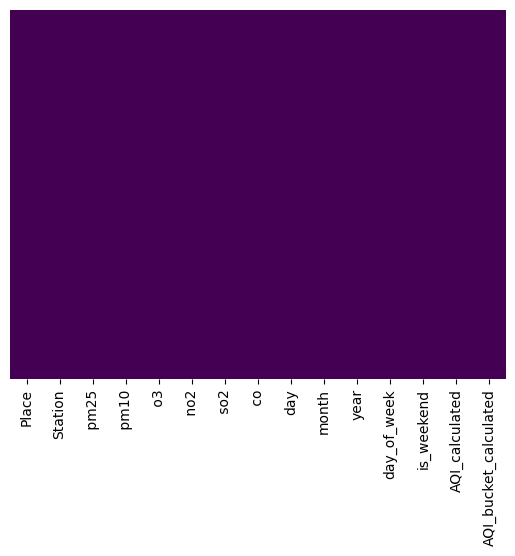

In [11]:
df=pd.concat([x,y],axis=1)
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')#checking for missing values

Split dependent and independent columns

In [12]:
X=df.iloc[:,:-2]
print(X)
y=df['AQI_bucket_calculated']
print(y)

        Place           Station          pm25      pm10            o3  \
0      mumbai            bandra -1.120958e-01 -0.072036  8.361489e+00   
1      mumbai            bandra -1.120958e-01 -0.072036  1.019922e+01   
2      mumbai            bandra -1.120958e-01 -0.072036  2.037398e+01   
3      mumbai            bandra -1.120958e-01 -0.089869  5.448011e+00   
4      mumbai            bandra -1.120958e-01 -0.089869  5.941062e+00   
...       ...               ...           ...       ...           ...   
20902  mumbai  sector-19a-nerul  2.261632e-16  0.000000 -8.271719e-01   
20903  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20904  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20905  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   
20906  mumbai  sector-19a-nerul  2.261632e-16  0.000000  1.592424e-16   

            no2           so2            co day month  year day_of_week  \
0     -0.861153  7.135995e-01  1.270158e-16   1 

**Encoding-Random Forest**

In [13]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

categorical_columns = ['Place', 'Station']
X_encoded = X.copy()

# Label encoding for selected categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X[col])

order = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]
ordinal_encoder = OrdinalEncoder(categories=[order])
y_encoded = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))
y_encoded=pd.DataFrame(y_encoded,columns=['AQI_bucket_calculated'])

**Grid Search for Random Forest**

In [14]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

forest_clf = RandomForestClassifier()

# Use a suitable scoring method for classification, such as 'accuracy'
random_search = RandomizedSearchCV(forest_clf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', return_train_score=True)

# Reshape y_encoded into a 1-dimensional array if needed
y_encoded_1d = y_encoded.values.ravel()

random_search.fit(X_encoded, y_encoded_1d)

# Best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}
Best Estimator: RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=2,
                       min_samples_split=10)


**Train-Test-Random Forest**

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 1

strat_shuff_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=42)

# Perform the split
for train_index, test_index in strat_shuff_split.split(X_encoded, y_encoded):
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y_encoded.iloc[train_index], y_encoded.iloc[test_index]

# Check the class distribution in the test dataset
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in the test dataset:")
print(class_distribution)


Class distribution in the test dataset:
{0.0: 247, 1.0: 3065, 2.0: 2151, 3.0: 2527, 4.0: 352, 5.0: 21}


PCA

In [18]:
from sklearn.decomposition import PCA
n_components = 2

In [22]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Display the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by each component:")
print(explained_variance_ratio)

# Optionally, convert PCA results to DataFrame for better readability
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

print("First few rows of PCA transformed training data:")
print(X_train_pca_df.head())

print("First few rows of PCA transformed test data:")
print(X_test_pca_df.head())


Explained variance ratio by each component:
[0.65468831 0.10596117]
First few rows of PCA transformed training data:
         PC1       PC2
0  -1.829937 -3.458006
1 -12.833585 -3.834175
2  -9.787521  1.019406
3  12.192777  0.506957
4  -4.842041 -4.658501
First few rows of PCA transformed test data:
         PC1       PC2
0   5.189024 -1.362758
1  11.198230  0.293808
2   7.223777  2.586860
3  -5.805195 -1.006893
4  -8.817603 -1.663814


y_train shape: (12544, 1)
y_test shape: (8363, 1)


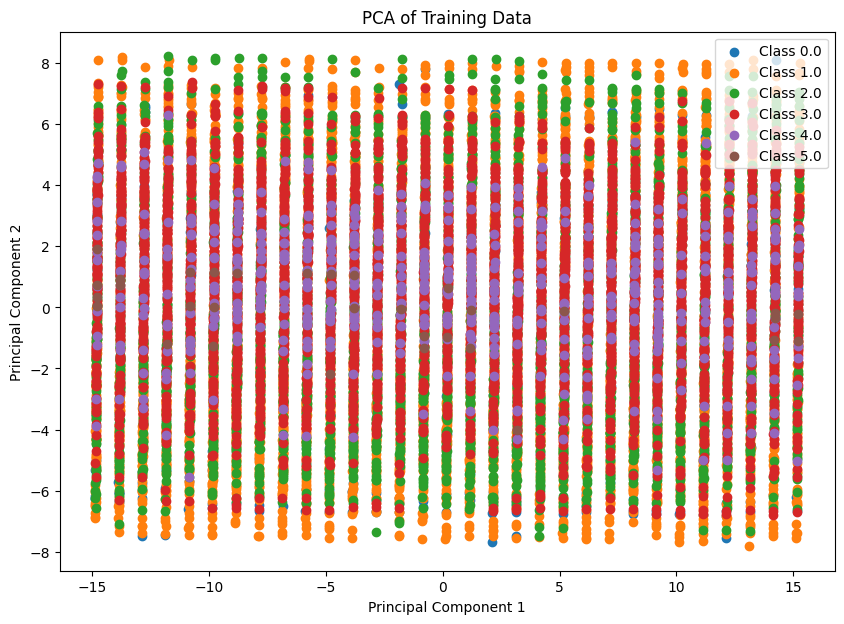

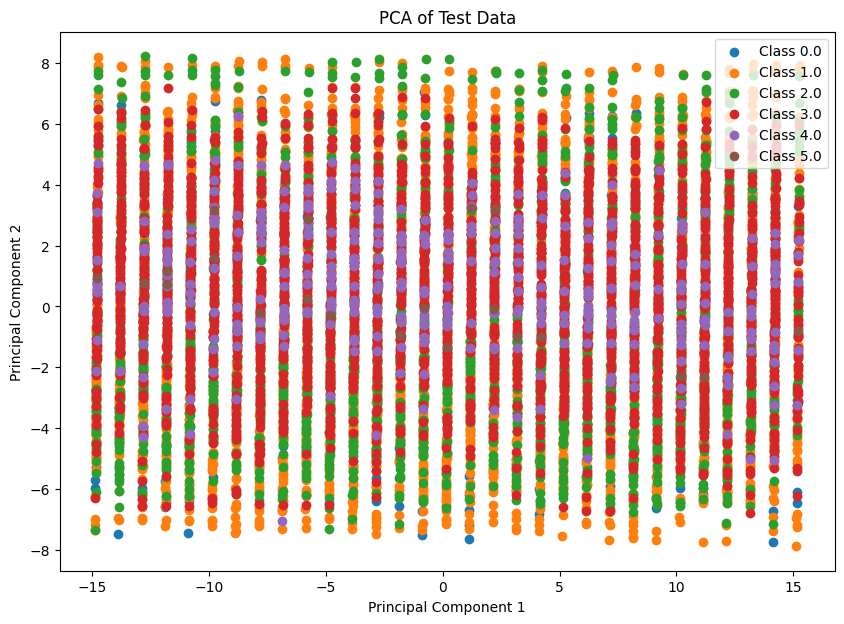

In [23]:
def plot_pca_scatter(X_pca, y, title):
    plt.figure(figsize=(10, 7))
    for class_value in np.unique(y):
        plt.scatter(X_pca[y == class_value, 0], X_pca[y == class_value, 1], label=f'Class {class_value}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Ensure y_train and y_test are one-dimensional arrays
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Plot PCA for training data
plot_pca_scatter(X_train_pca, y_train.to_numpy().ravel(), 'PCA of Training Data')

# Plot PCA for test data
plot_pca_scatter(X_test_pca, y_test.to_numpy().ravel(), 'PCA of Test Data')

**Random Forest Model**

In [24]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)

best_params = {
    'n_estimators': 90,
    'min_samples_split': 10,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'max_depth': 6,
    'class_weight':'balanced'
}

# Convert y_train to a 1-dimensional array
y_train_1d = y_train.values.ravel()
# Initialize Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params)
rf_classifier.fit(X_train, y_train_1d)  # Use y_train_1d instead of y_train
y_pred = rf_classifier.predict(X_test)

from sklearn.metrics import accuracy_score,precision_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9528877197178046


**ROC Curve (Random Forest)**

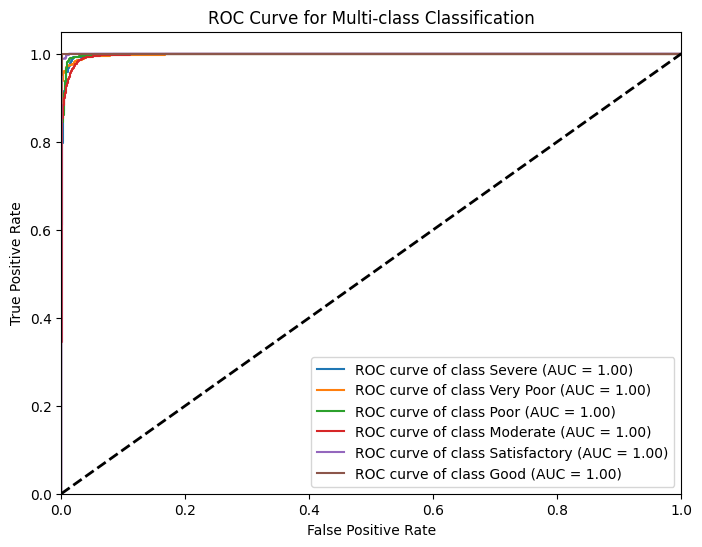

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
classes=[0,1,2,3,4,5]
y_prob=rf_classifier.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test == classes[i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names corresponding to class labels
class_names = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


**Confusion Matrix Random Forest**

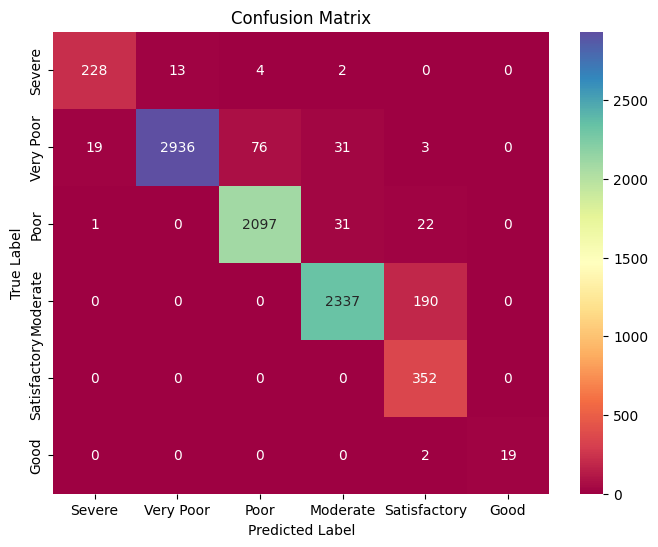

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,y_pred)
sns.color_palette("Spectral", as_cmap=True)
categories = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories,cmap="Spectral")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**SVM Encoding**

In [27]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

categorical_columns = ['Place', 'Station']
X_encoded = X.copy()

# Label encoding for selected categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X[col])

order = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]
ordinal_encoder = OrdinalEncoder(categories=[order])
y_encoded = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))
y_encoded=pd.DataFrame(y_encoded,columns=['AQI_bucket_calculated'])
X2=X_encoded
y2=y_encoded

**Grid Search SVM**

In [28]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

np.random.seed(42)

# Define a smaller parameter grid for SVM
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']

}

svm_clf = SVC()

# Use a suitable scoring method for classification, such as 'accuracy'
random_search = RandomizedSearchCV(
    svm_clf,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    return_train_score=True
)

# Reshape y_encoded into a 1-dimensional array if needed
y2_1d = y2.values.ravel()

random_search.fit(X2, y2_1d)

# Best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)


Best Parameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}
Best Estimator: SVC(C=1, kernel='linear')


**Train-Test-SVM**

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 1
strat_shuff_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.4, random_state=42)

# Perform the split
for train_index, test_index in strat_shuff_split.split(X2, y2):
    X2_train, X2_test = X2.iloc[train_index], X2.iloc[test_index]
    y2_train, y2_test = y2.iloc[train_index], y2.iloc[test_index]

# the class distribution in the test dataset
unique, counts = np.unique(y2_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in the test dataset:")
print(class_distribution)

Class distribution in the test dataset:
{0.0: 247, 1.0: 3065, 2.0: 2151, 3.0: 2527, 4.0: 352, 5.0: 21}


In [31]:
n_components = 2
pca = PCA(n_components=n_components)
X2_train_pca = pca.fit_transform(X2_train)
X2_test_pca = pca.transform(X2_test)

# Display the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by each component:")
print(explained_variance_ratio)

# Optionally, convert PCA results to DataFrame for better readability
X2_train_pca_df = pd.DataFrame(X2_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
X2_test_pca_df = pd.DataFrame(X2_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])

print("First few rows of PCA transformed training data:")
print(X2_train_pca_df.head())

print("First few rows of PCA transformed test data:")
print(X2_test_pca_df.head())


Explained variance ratio by each component:
[0.65468831 0.10596117]
First few rows of PCA transformed training data:
         PC1       PC2
0  -1.829937 -3.458006
1 -12.833585 -3.834175
2  -9.787521  1.019406
3  12.192777  0.506957
4  -4.842041 -4.658501
First few rows of PCA transformed test data:
         PC1       PC2
0   5.189024 -1.362758
1  11.198230  0.293808
2   7.223777  2.586860
3  -5.805195 -1.006893
4  -8.817603 -1.663814


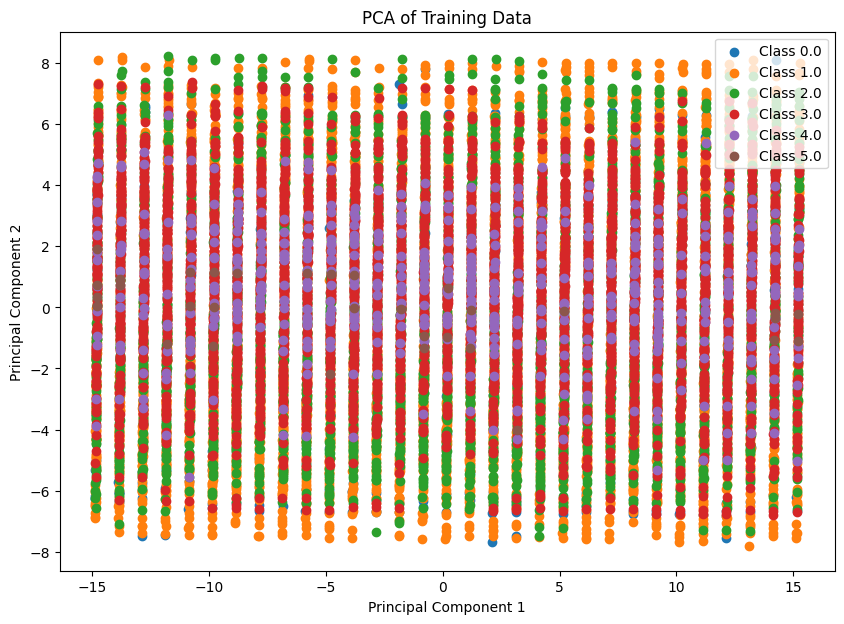

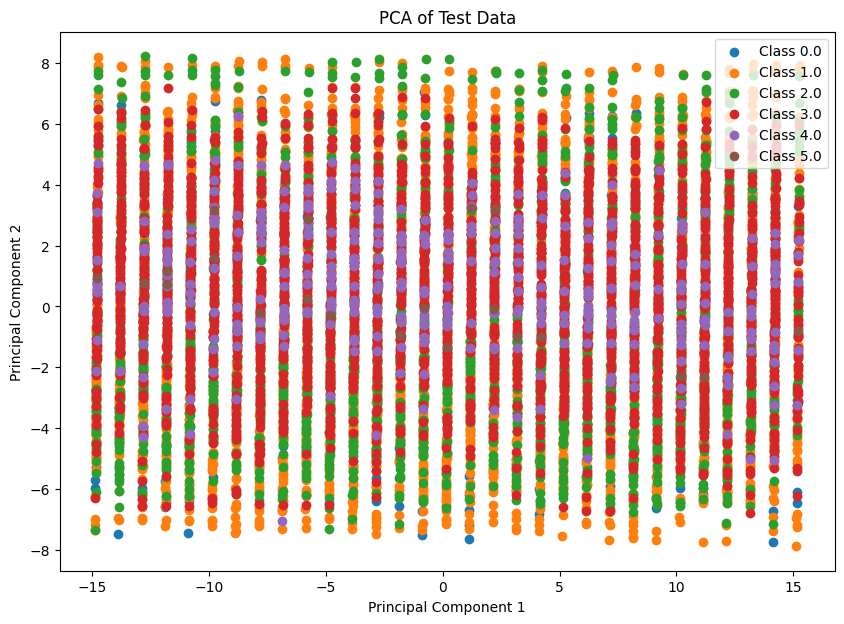

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [39]:
def plot_pca_scatter(X_pca, y, title):
    plt.figure(figsize=(10, 7))
    for class_value in np.unique(y):
        plt.scatter(X_pca[y == class_value, 0], X_pca[y == class_value, 1], label=f'Class {class_value}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot PCA for training data
plot_pca_scatter(X2_train_pca, y2_train.to_numpy().ravel(), 'PCA of Training Data')

# Plot PCA for test data
plot_pca_scatter(X2_test_pca, y2_test.to_numpy().ravel(), 'PCA of Test Data')

# Initialize and train an SVM model on PCA-transformed data
svm_clf = SVC()
svm_clf.fit(X2_train_pca, y2_train)


**SVM MODEL**

In [40]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Best parameters for SVM
best_params_svm = {
    'C': 1,
    'kernel': 'linear',
    'gamma': 'scale'
}

# Convert y_train to a 1-dimensional array if needed
y2_train_1d = y2_train.values.ravel()
svm_clf = SVC(**best_params_svm)

svm_clf.fit(X2_train, y2_train_1d)
y2_pred = svm_clf.predict(X2_test)

accuracy = accuracy_score(y2_test, y2_pred)
print("Accuracy:", accuracy)

Accuracy: 0.891665670214038


**ROC CURVE SVM**

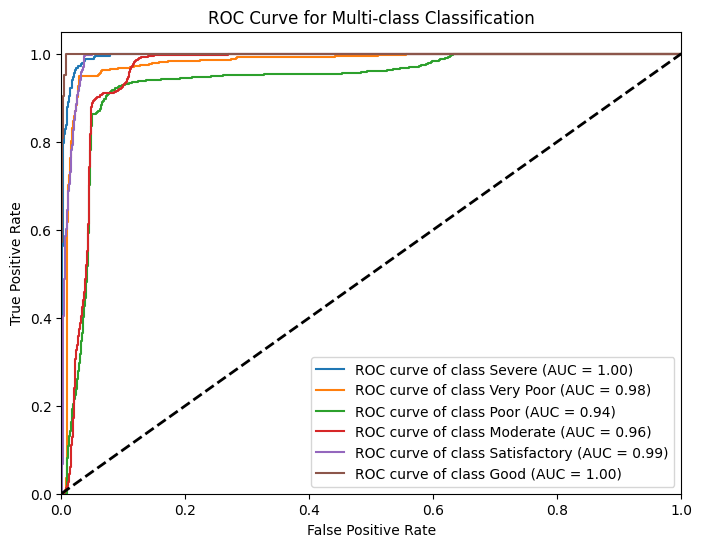

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

y2_prob = svm_clf.decision_function(X2_test)

#class names corresponding to class labels
class_names = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]

# Calculate ROC curve and AUC for each class
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y2_test == i, y2_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

**CONFUSION MATRXI(SVM)**

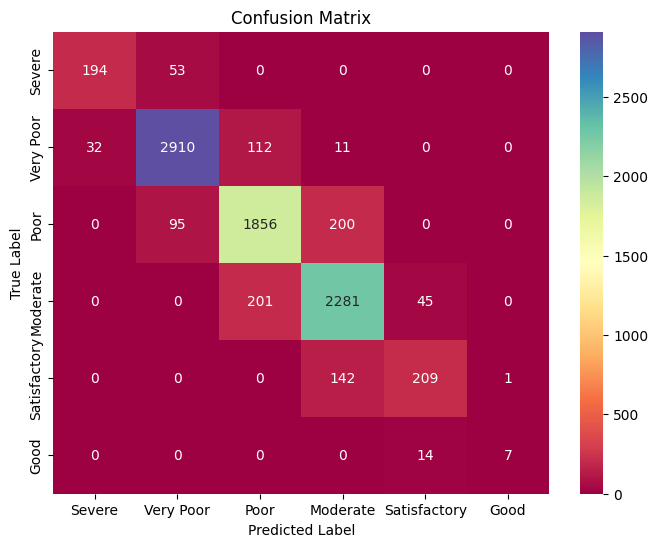

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y2_test,y2_pred)
sns.color_palette("Spectral", as_cmap=True)
categories = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories,cmap="Spectral")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**ENSEMBLE MODEL (Voting Classifier)**

In [46]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

categorical_columns = ['Place', 'Station']
X_encoded = X.copy()
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_encoded[col] = label_encoder.fit_transform(X[col])

order = ["Severe", "Very Poor", "Poor", "Moderate", "Satisfactory", "Good"]
ordinal_encoder = OrdinalEncoder(categories=[order])
y_encoded = ordinal_encoder.fit_transform(y.values.reshape(-1, 1))
y_encoded = pd.DataFrame(y_encoded, columns=['AQI_bucket_calculated'])

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.4, random_state=42)

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Randomized search for Random Forest
rf_clf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf_clf, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', return_train_score=True)
random_search_rf.fit(X_train, y_train.values.ravel())

# Best parameters for Random Forest
best_params_rf = random_search_rf.best_params_

# Initialize Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params_rf)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Randomized search for SVM
svm_clf = SVC()
random_search_svm = RandomizedSearchCV(svm_clf, param_distributions=param_grid_svm, n_iter=5, cv=3, scoring='accuracy', return_train_score=True)
random_search_svm.fit(X_train, y_train.values.ravel())

# Best parameters for SVM
best_params_svm = random_search_svm.best_params_

# Initialize SVM classifier with the best parameters
svm_classifier = SVC(**best_params_svm, probability=True)  # Enable probability estimates for soft voting

# Create the ensemble model with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('random_forest', rf_classifier),
        ('svm', svm_classifier)
    ],
    voting='soft'  # Soft voting for probability estimates
)

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train.values.ravel())

# Predict on the test data
y_pred = ensemble_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9736936506038503


**ROC CURVE(VOTING CLASSIFIER)**

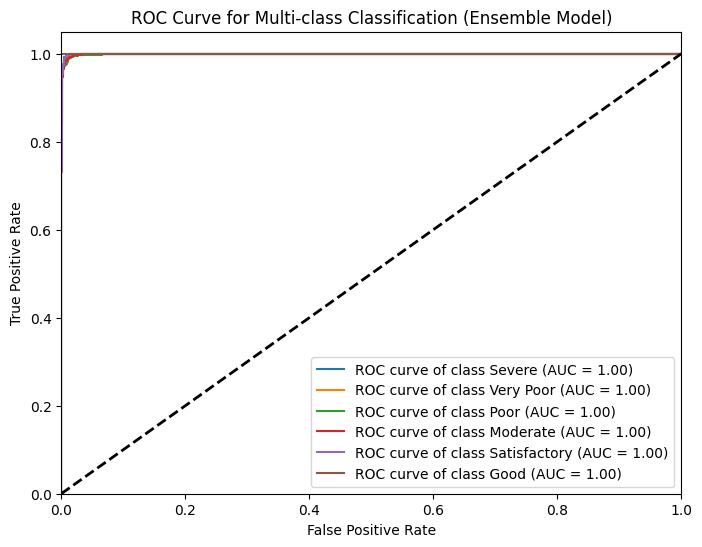

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate decision function for the ensemble model
y2_prob_ensemble = ensemble_model.predict_proba(X2_test)

# Calculate ROC curve and AUC for each class
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y2_test == i, y2_prob_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification (Ensemble Model)')
plt.legend(loc="lower right")
plt.show()


**CONFUSION MATRIX(VOTING CLASSIFIER)**

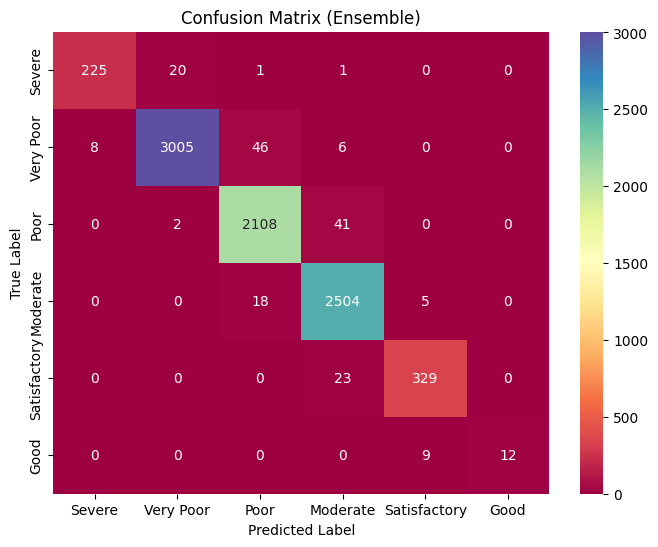

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict using the ensemble model
y2_pred_ensemble = ensemble_model.predict(X2_test)
cm_ensemble = confusion_matrix(y2_test, y2_pred_ensemble)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap="Spectral")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Ensemble)')
plt.show()


In [ ]:
"""import requests
import pandas as pd

# API endpoint for city feed
url = "https://api.waqi.info/feed/bengaluru/"

# Your private API token
token = "db5ba0d592e548cdc5079a24fdbf1aa0ff5b5496"

# Parameters for the API request
params = {
    "token": token,
    "start": "2024-05-01",  # Start date of the custom date range
    "end": "2024-05-12"      # End date of the custom date range
}

# Make the API request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Check if the status is "ok"
    if data['status'] == 'ok':
        # Extract relevant information
        idx = data['data']['idx']
        aqi = data['data']['aqi']
        time = data['data']['time']['s']
        city_name = data['data']['city']['name']
        pm25 = data['data']['iaqi']['pm25']['v']

        # Create a DataFrame with the extracted information
        df = pd.DataFrame({
            "City": [city_name],
            "AQI": [aqi],
            "Time": [time],
            "PM2.5": [pm25]
        })

        # Print the DataFrame
        print(df)
    else:
        # Handle error response
        print("Error:", data['message'])
else:
    # Handle errors
    print("Failed to fetch data. Status code:", response.status_code)"""


In [ ]:
"""import requests

# API endpoint
url = "https://api.data.gov.in/resource/3b01bcb8-0b14-4abf-b6f2-c1bfd384ba69"

# API key
api_key = "579b464db66ec23bdd000001cdd3946e44ce4aad7209ff7b23ac571b"

# Format
format = "json"  # or "xml" or "csv"

# Parameters for data extraction (modify as needed)
#start_date = "2024-04-20"  # Start date for data extraction
#end_date = "2024-04-30"    # End date for data extraction
limit = 10                 # Maximum number of records to return

# Parameters for the API request
params = {
    "api-key": api_key,
    "format": format,
    "offset": 200,
    "limit": limit
    #"filters[date]": f"{start_date},{end_date}"  # Filter data by date range
}

# Make the API request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Extract relevant information from the response
    # Process the data as needed
    print(data)
else:
    # Handle errors
    print("Failed to fetch data. Status code:", response.status_code)"""
